In [2]:
import pandas as pd
from datetime import datetime
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

## Read training and test datasets

In [5]:
# helper function for reading datatset
def read_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # convert it to datatime

    return df

In [6]:
df_train = read_data('data/kospi_train.csv')
df_test = read_data('data/kospi_test.csv')

len(df_train), len(df_test)

(986, 244)

In [7]:
# the training dataset has daily KOSPI index from 2019 to 2022
df_train

,Date,Open,Low,High,Close,Volume
0,2019-01-02,2050.550049,2004.270020,2053.449951,2010.000000,326400
1,2019-01-03,2011.810059,1991.650024,2014.719971,1993.699951,428000
2,2019-01-04,1992.400024,1984.530029,2011.560059,2010.250000,409000
3,2019-01-07,2034.239990,2030.900024,2048.060059,2037.099976,440200
4,2019-01-08,2038.680054,2023.589966,2042.699951,2025.270020,397800
...,...,...,...,...,...,...
981,2022-12-23,2325.860107,2311.899902,2333.080078,2313.689941,367000
982,2022-12-26,2312.540039,2304.199951,2321.919922,2317.139893,427600
983,2022-12-27,2327.520020,2321.479980,2335.989990,2332.790039,448300
984,2022-12-28,2296.449951,2276.899902,2296.449951,2280.449951,405700


In [8]:
# the test dataset has daily KOSPI index in 2023
df_test

,Date,Open,Low,High,Close,Volume
0,2023-01-02,2249.949951,2222.370117,2259.879883,2225.669922,346100
1,2023-01-03,2230.979980,2180.669922,2230.979980,2218.679932,410000
2,2023-01-04,2205.979980,2198.820068,2260.060059,2255.979980,412700
3,2023-01-05,2268.199951,2252.969971,2281.389893,2264.649902,430800
4,2023-01-06,2253.399902,2253.270020,2300.620117,2289.969971,398300
...,...,...,...,...,...,...
239,2023-12-21,2598.370117,2587.159912,2610.810059,2600.020020,578300
240,2023-12-22,2617.719971,2599.510010,2621.370117,2599.510010,466000
241,2023-12-26,2609.439941,2594.649902,2612.139893,2602.590088,439500
242,2023-12-27,2599.350098,2590.080078,2613.500000,2613.500000,349700


## Part 1. Train regression models to predict the next day's `close` using `Open`, `Low`, `High`, `Close`, `Volume` of previous days as predictors using *only* df_train. Cross-validate to select the best model. Evaluate the accuracy of your model using `df_test`.


In [9]:
# PART 1: Train regression models to predict next day's close
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Create lag features for previous day's Open, High, Low, Close, Volume
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in feature_cols:
    df_train[f'{col}_lag1'] = df_train[col].shift(1)
    df_test[f'{col}_lag1'] = df_test[col].shift(1)

# Impute NaN values with mean for lag features
lag_cols = [f'{col}_lag1' for col in feature_cols]
imputer = SimpleImputer(strategy='mean')
df_train[lag_cols] = imputer.fit_transform(df_train[lag_cols])
df_test[lag_cols] = imputer.transform(df_test[lag_cols])

df_train_feat = df_train.dropna().copy()
df_test_feat = df_test.copy()

X_train = df_train_feat[[f'{col}_lag1' for col in feature_cols]]
y_train = df_train_feat['Close']
X_test = df_test_feat[[f'{col}_lag1' for col in feature_cols]]

def evaluate_model(model):
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    rmse = evaluate_model(model)
    results[name] = rmse

results

c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.020e+04, tolerance: 1.296e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+05, tolerance: 6.177e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e+05, toleranc

{'LinearRegression': 37.69134337749209,
 'Ridge': 37.69126356037331,
 'Lasso': 37.802261949275035,
 'RandomForest': 164.62441118887847}

In [10]:
# Fit the best model and evaluate on test set
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
# Since test set may have NaNs in lag features, handle them
mask = ~np.isnan(X_test).any(axis=1)
test_rmse = mean_squared_error(df_test_feat['Close'][mask], y_pred[mask], squared=False)
print(f"Best model: {best_model_name}, Test RMSE: {test_rmse:.4f}")

relative_error = np.abs(y_pred - df_test_feat['Close']) / df_test_feat['Close']
within_5pct = (relative_error <= 0.05).mean()
print(f"Probability that predictions are within ±5% of actual values in the test set: {within_5pct:.2%}")

Best model: Ridge, Test RMSE: 29.5706
Probability that predictions are within ±5% of actual values in the test set: 99.18%


c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Part 2. Extend the regression model by adding some extra features of your choice. You can use any statistics publicly available. 

In [11]:
# PART 2: Add extra features (e.g., moving averages, returns)
df_train['MA5'] = df_train['Close'].rolling(window=5).mean()
df_train['Return1'] = df_train['Close'].pct_change(1)
df_test['MA5'] = df_test['Close'].rolling(window=5).mean()
df_test['Return1'] = df_test['Close'].pct_change(1)

# Impute NaN values for new features as well
feature_cols_extended = [f'{col}_lag1' for col in feature_cols] + ['MA5', 'Return1']
imputer2 = SimpleImputer(strategy='mean')
df_train[feature_cols_extended] = imputer2.fit_transform(df_train[feature_cols_extended])
df_test[feature_cols_extended] = imputer2.transform(df_test[feature_cols_extended])

df_train_feat2 = df_train.dropna().copy()
df_test_feat2 = df_test.copy()

X_train2 = df_train_feat2[feature_cols_extended]
y_train2 = df_train_feat2['Close']
X_test2 = df_test_feat2[feature_cols_extended]

results2 = {}
for name, model in models.items():
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train2, y_train2, cv=tscv, scoring='neg_root_mean_squared_error')
    results2[name] = -scores.mean()

results2

c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.883e+04, tolerance: 1.296e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e+05, tolerance: 6.177e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+05, toleranc

{'LinearRegression': 15.645231173384952,
 'Ridge': 35.661759622589564,
 'Lasso': 37.6047588214066,
 'RandomForest': 161.06868964538393}

In [12]:
# Fit the best extended model and evaluate on test set
best_model_name2 = min(results2, key=results2.get)
best_model2 = models[best_model_name2]
best_model2.fit(X_train2, y_train2)

y_pred2 = best_model2.predict(X_test2)
mask2 = ~np.isnan(X_test2).any(axis=1)
test_rmse2 = mean_squared_error(df_test_feat2['Close'][mask2], y_pred2[mask2], squared=False)
print(f"Best extended model: {best_model_name2}, Test RMSE: {test_rmse2:.4f}")

#+-5%
relative_error2 = np.abs(y_pred2 - df_test_feat2['Close']) / df_test_feat2['Close']
within_5pct2 = (relative_error2 <= 0.05).mean()
print(f"Probability that extended predictions are within ±5% of actual values in the test set: {within_5pct2:.2%}")

Best extended model: LinearRegression, Test RMSE: 17.0855
Probability that extended predictions are within ±5% of actual values in the test set: 99.59%


c:\Users\ggg09\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


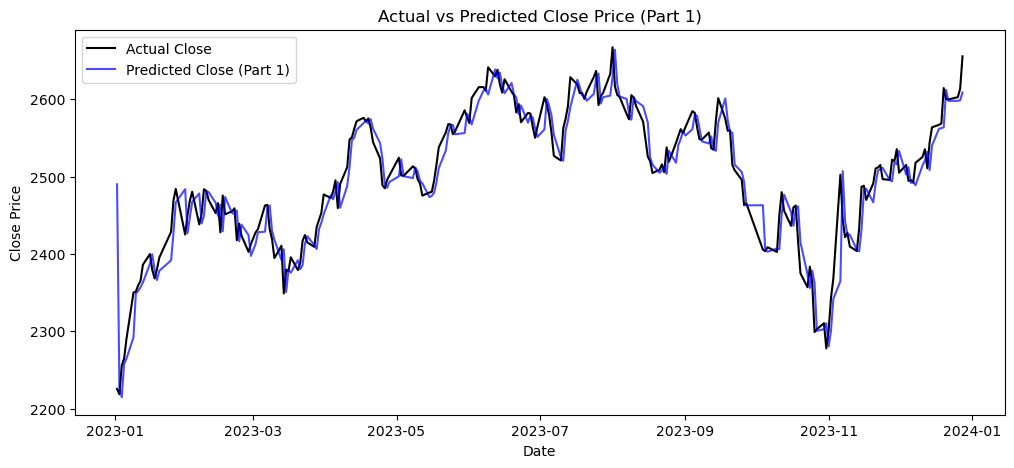

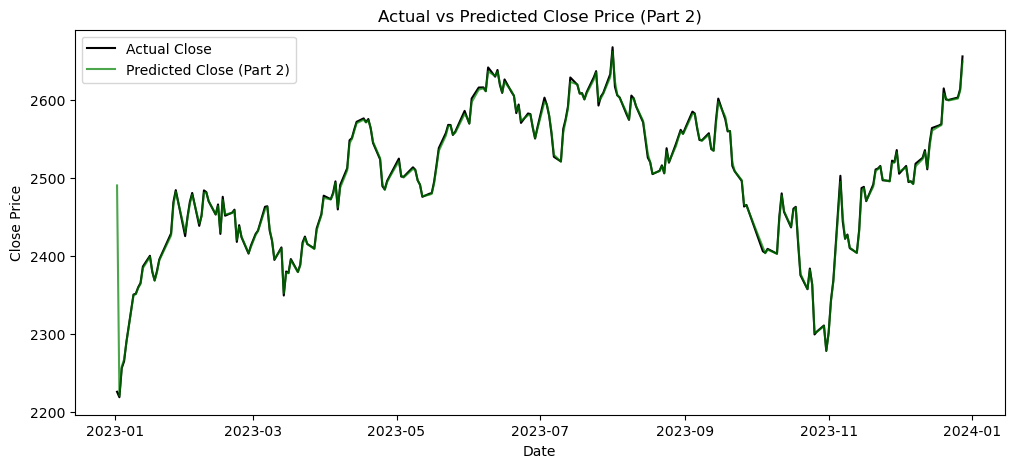

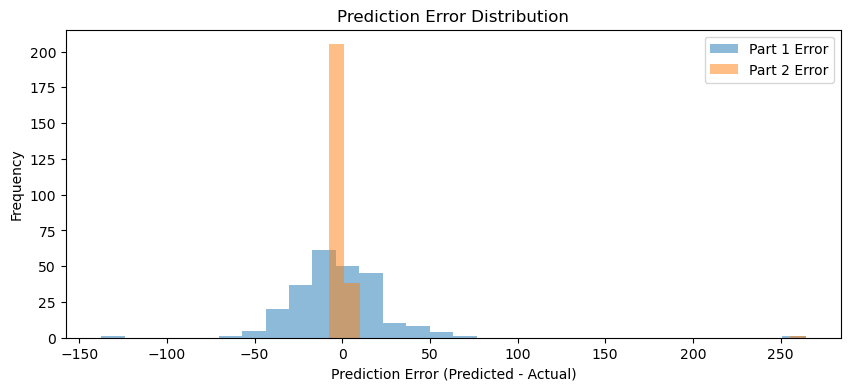

In [13]:
# 시각화: 실제값 vs 예측값 (Part 1)
plt.figure(figsize=(12,5))
plt.plot(df_test_feat['Date'].values, df_test_feat['Close'].values, label='Actual Close', color='black')
plt.plot(df_test_feat['Date'].values, y_pred, label='Predicted Close (Part 1)', color='blue', alpha=0.7)
plt.title('Actual vs Predicted Close Price (Part 1)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 시각화: 실제값 vs 예측값 (Part 2)
plt.figure(figsize=(12,5))
plt.plot(df_test_feat2['Date'].values, df_test_feat2['Close'].values, label='Actual Close', color='black')
plt.plot(df_test_feat2['Date'].values, y_pred2, label='Predicted Close (Part 2)', color='green', alpha=0.7)
plt.title('Actual vs Predicted Close Price (Part 2)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 시각화: 예측 오차 분포 (Part 1 & 2)
plt.figure(figsize=(10,4))
plt.hist((y_pred - df_test_feat['Close'].values), bins=30, alpha=0.5, label='Part 1 Error')
plt.hist((y_pred2 - df_test_feat2['Close'].values), bins=30, alpha=0.5, label='Part 2 Error')
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.legend()
plt.show()